In [1]:
%reset -f

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from pyDOE3 import lhs  # For Latin Hypercube Sampling

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Creating the mesh just like fenics as a 1by1 square with triangle mesh
#outfile = "C:\\Users\\xxxxxxxxxxxxxxxxxxxx\\u_PINN_outputfile.txt"

N1, N2, N3, N4, N5, N6 = 114, 436, 1642, 6381, 25315, 100266
N = N4
# Inflow points
I1, I2, I3, I4, I5, I6 = N1/7, N2/7, N3/7, N4/7, N5/7, N6/7
I = int(N/7)
x = np.linspace(0, 1, N + 1)
y = np.linspace(0, 1, N + 1)
squaresize = 1


C:\Users\chris\AppData\Local\Temp\ipykernel_12272\1981163657.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_inlet_boundary = torch.tensor(4 * inlet_coords[:,1] * (1.0 - inlet_coords[:,1])).to(device)  #  parabolic profile


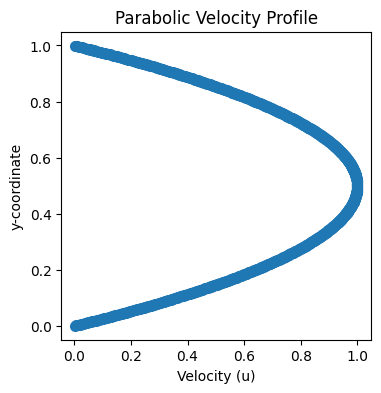

In [4]:
# Create collocation points using LHS
lhs_samples = lhs(2, samples= N)
x_collocation = lhs_samples[:, 0]   
y_collocation = lhs_samples[:, 1] 
collocation_coords = torch.tensor(np.column_stack((x_collocation, y_collocation)), dtype=torch.float32).to(device)

# Generate inlet boundary points and apply parabolic inlet condition 
lhs_samples_inlet = squaresize* lhs(2, samples=I)
x_inlet = lhs_samples_inlet[:, 0] 
y_inlet = lhs_samples_inlet[:, 1] 
inlet_coords = torch.tensor(np.column_stack((x_inlet, y_inlet)), dtype=torch.float32).to(device)
u_inlet_boundary = torch.tensor(4 * inlet_coords[:,1] * (1.0 - inlet_coords[:,1])).to(device)  #  parabolic profile
#u_inlet_boundary = torch.tensorones(I).to(device) # u = 1 on left wall 
v_inlet_boundary = torch.zeros(I).to(device)  # v = 0 m/s

# top and bottom boundary
lhs_samples_top = squaresize* lhs(2, samples=I)
x_top = lhs_samples_inlet[:, 0] 
y_top = lhs_samples_inlet[:, 1] 
top_coords = torch.tensor(np.column_stack((x_top, y_top)), dtype=torch.float32).to(device)
u_top_boundary = torch.zeros(I).to(device)  # u = 0 m/s
v_top_boundary = torch.zeros(I).to(device)  # v = 0 m/s
#
lhs_samples_bot = squaresize* lhs(2, samples=I)
x_bot = lhs_samples_inlet[:, 0] 
y_bot = lhs_samples_inlet[:, 1] 
bot_coords = torch.tensor(np.column_stack((x_bot, y_bot)), dtype=torch.float32).to(device)
u_bot_boundary = torch.zeros(I).to(device)  # u = 0 m/s
v_bot_boundary = torch.zeros(I).to(device)  # v = 0 m/s

# Plotting the inflow
x = inlet_coords[:, 0].cpu().numpy()  # x-coordinates (should all be 0)
y = inlet_coords[:, 1].cpu().numpy()  # y-coordinates (0 to 1)
u = u_inlet_boundary.cpu().numpy()    # u-velocity (parabolic profile)
v = v_inlet_boundary.cpu().numpy()    # v-velocity (should all be 0)

# Additional plot to show the exact parabolic profile
plt.figure(figsize=(4, 4))
plt.scatter(u, y, linewidth=2)
plt.title("Parabolic Velocity Profile")
plt.xlabel("Velocity (u)")
plt.ylabel("y-coordinate")
plt.show()

In [5]:
# Define the Stokes PINN model
class StokesPINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.Tanh()
        self.layer1 = nn.Linear(2, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, 32)
        self.layer4 = nn.Linear(32, 32)
        self.layer5 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, 3)

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.activation(self.layer4(x))
        x = self.activation(self.layer5(x))
        return self.output_layer(x)  # [u, v, p]
    
model = StokesPINN().to(device)

In [6]:
# Ensure input has gradients enabled
def gradients(u, x, order=1):
    for _ in range(order):
        u = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return u


def compute_residuals(model, x, mu):
    x.requires_grad_(True)
    output = model(x)
    u, v, p = output[:, 0], output[:, 1], output[:, 2]

    # First-order derivatives
    grad_u = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x, u_y = grad_u[:, 0], grad_u[:, 1]

    grad_v = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_x, v_y = grad_v[:, 0], grad_v[:, 1]

    grad_p = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    p_x, p_y = grad_p[:, 0], grad_p[:, 1]

    # Second-order derivatives (Laplacians)
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(u_y, x, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1]
    v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0][:, 0]
    v_yy = torch.autograd.grad(v_y, x, grad_outputs=torch.ones_like(v_y), create_graph=True)[0][:, 1]

    # PDE residuals (Stokes equations: -Δu + ∇p = f)
    f1 = p_x - mu*(u_xx + u_yy)
    f2 = p_y - mu*(v_xx + v_yy)

    div_u = u_x + v_y

    return f1, f2, div_u


In [7]:
# Boundary loss function for applying boundary conditions
def boundary_loss(model, boundary_coords, u_boundary, v_boundary):
    u_pred, v_pred = model(boundary_coords)[:, 0], model(boundary_coords)[:, 1]
    loss_Bc =  ((u_pred - u_boundary) ** 2 + (v_pred - v_boundary) ** 2).mean()
    return loss_Bc

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []
mu = 1.0

# Optimizer setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)  # Optional learning rate scheduler
num_epochs = 3000 # Number of training epochs
nu = mu  # Kinematic viscosity from the research paper
loss_history = []
fix_idx = torch.argmin(torch.norm(collocation_coords - torch.tensor([[0.0, 0.0]]), dim=1))


for epoch in range(num_epochs):
    optimizer.zero_grad()
    # Compute physics-based and boundary losses
    f1, f2, div_u = compute_residuals(model, collocation_coords, mu)
    phy_loss = (f1**2).mean() + (f2**2).mean() + 1*(div_u**2).mean()
    bound_loss_inlet = boundary_loss(model, inlet_coords, u_inlet_boundary, v_inlet_boundary)
    bound_loss_top = boundary_loss(model, top_coords, u_top_boundary, v_top_boundary)
    bound_loss_bot = boundary_loss(model, bot_coords, u_bot_boundary, v_bot_boundary)

    # fixing the pressure
    x_fix = collocation_coords[fix_idx].unsqueeze(0)
    p_fix = model(x_fix)[:, 2]  # extract pressure at that point
    loss_pressure = (p_fix - 0.0)**2  # fix pressure to 0.0 at 0,0
    total_loss = 1* phy_loss + 1* bound_loss_inlet + 1*bound_loss_top+ 1*bound_loss_bot + 1*loss_pressure
    total_loss.backward()
    
    # Gradient clipping for stability
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)

    optimizer.step()
    scheduler.step()  # Optional scheduler step
    loss_history.append(total_loss.item())

    # Print progress every 500 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Total Loss = {total_loss.item():.6f}, Physics Loss = {phy_loss.item():.6f}")


Epoch 0: Total Loss = 0.600386, Physics Loss = 0.003792
Epoch 500: Total Loss = 0.360100, Physics Loss = 0.001375
Epoch 1000: Total Loss = 0.356507, Physics Loss = 0.000660
Epoch 1500: Total Loss = 0.356059, Physics Loss = 0.000378
Epoch 2000: Total Loss = 0.355860, Physics Loss = 0.000251
Epoch 2500: Total Loss = 0.355762, Physics Loss = 0.000164


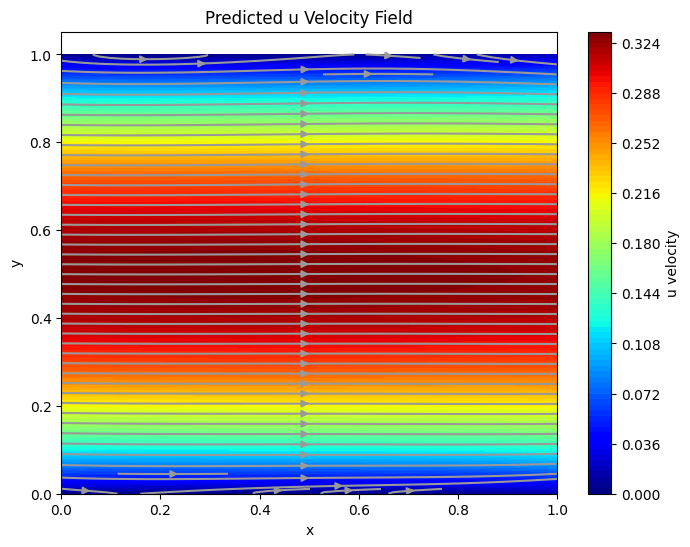

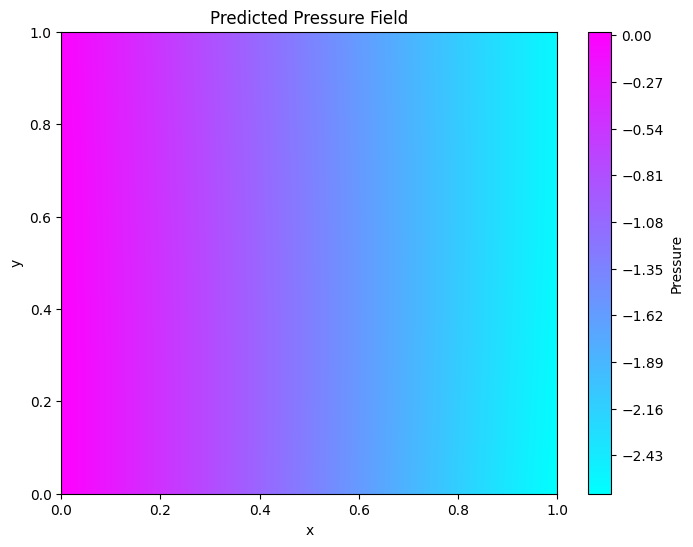

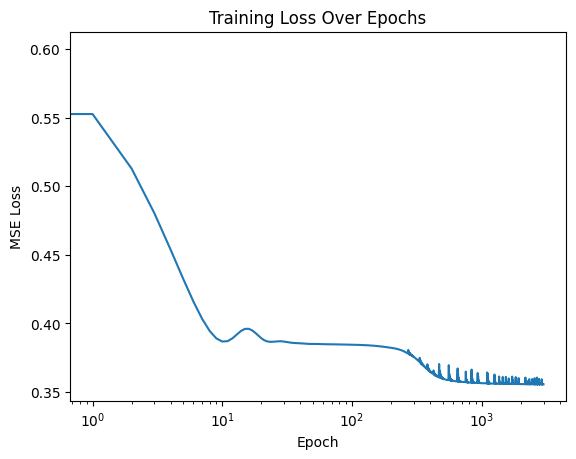

In [10]:
# Improved visualization with gradient color maps
with torch.no_grad():
    x_plot, y_plot = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
    coords_plot = torch.tensor(np.column_stack((x_plot.ravel(), y_plot.ravel())), dtype=torch.float32).to(device)
    outputs = model(coords_plot)
    u_pred = outputs[:, 0].cpu().numpy().reshape(100, 100)
    v_pred = outputs[:, 1].cpu().numpy().reshape(100, 100)
    p_pred = outputs[:, 2].cpu().numpy().reshape(100, 100)

    # Plot u velocity field with gradient colors
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.streamplot(x_plot, y_plot, u_pred, v_pred, density=1.5, color=(0.6, 0.6, 0.6))
    contour = ax.contourf(x_plot, y_plot, u_pred, levels=100, cmap='jet')  # Increased levels for smoother gradients
    plt.colorbar(contour, label="u velocity")
    ax.set_title("Predicted u Velocity Field")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.show()

    # Plot pressure field with gradient colors
    fig, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(x_plot, y_plot, p_pred, levels=1000, cmap='cool')  # Increased levels for smoother gradients
    plt.colorbar(contour, label="Pressure")
    ax.set_title("Predicted Pressure Field")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.show()
   
    # plotting the loss
    plt.figure()
    plt.plot(loss_history)
    plt.xscale('log') 
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.show()

    # Build a regular grid  over [0,1] × [0,1]
    n_axis = 64    # nodes per axis 
    xs = np.linspace(0.0, 1.0, n_axis)
    ys = np.linspace(0.0, 1.0, n_axis)
    x_grid, y_grid = np.meshgrid(xs, ys)         

    # Stack into an tensor 
    coords_val = torch.tensor(np.column_stack((x_grid.ravel(), y_grid.ravel())),dtype=torch.float32, device=device)

    # Evaluate the network at those points
    with torch.no_grad():
        pred = model(coords_val)        
        u_val = pred[:, 0].cpu().numpy()
        v_val = pred[:, 1].cpu().numpy() 
        p_val = pred[:, 2].cpu().numpy()

    u_grid = u_val.reshape(n_axis, n_axis)
    v_grid = v_val.reshape(n_axis, n_axis)
    p_grid = p_val.reshape(n_axis, n_axis)


    #Save to a text file
    # np.savetxt(outfile_vel,u_val,fmt="%.7f",comments="")
    # np.savetxt(outfile_pres,p_val,fmt="%.7f",comments="")